<a href="https://colab.research.google.com/github/zheyuzy/GARCH-LSTM-model-on-ETH-BTC-pair/blob/main/GARCH_LSTM_Long_Short_Pair_Trading_Strategies_on_ETH_BTC_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch
!pip install alpaca-py
!pip install python-dotenv
!pip install ta
!pip install tensorflow
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=308a90def6e2708720bf40434c089bfeb8c6b3f3df2bd9d22f835329cd752071
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
APCA_API_KEY_ID="PK1B6UD0BZJM3QZX46YX"
APCA_API_SECRET_KEY="FUkcvqzmUaF01SOiMTE65xEYYW2n8kUtEtqhQMZQ"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import shap
import tensorflow as tf
from arch import arch_model
from datetime import datetime
from dotenv import load_dotenv
from statsmodels.stats.diagnostic import acorr_ljungbox
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, Layer, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Initialize the Alpaca CryptoHistoricalDataClient with credentials
client = CryptoHistoricalDataClient(
    api_key=os.getenv("APCA_API_KEY_ID"),
    secret_key=os.getenv("APCA_API_SECRET_KEY")
)

# Define the start and end dates for the data retrieval
start_date = datetime(2021, 1, 1)
end_date = datetime.now()

# Create a CryptoBarsRequest for BTC/USDT and ETH/USDT
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USDT", "ETH/USDT"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

# Retrieve the historical bar data
bars = client.get_crypto_bars(request_params)

# Convert the data to a pandas DataFrame and display it
df = bars.df
print(df.head())


                                        open      high       low     close  \
symbol   timestamp                                                           
BTC/USDT 2021-01-01 06:00:00+00:00  29202.77  29611.51  28649.46  29596.45   
         2021-01-02 06:00:00+00:00  29592.30  34187.48  29459.22  33739.29   
         2021-01-03 06:00:00+00:00  33790.49  34776.59  32300.00  32808.20   
         2021-01-04 06:00:00+00:00  32834.48  33392.99  27500.00  30416.25   
         2021-01-05 06:00:00+00:00  30481.36  35755.02  29937.69  34964.28   

                                         volume  trade_count          vwap  
symbol   timestamp                                                          
BTC/USDT 2021-01-01 06:00:00+00:00   275.555320      12027.0  29219.342240  
         2021-01-02 06:00:00+00:00   757.022383      25410.0  31804.509959  
         2021-01-03 06:00:00+00:00   694.494847      28315.0  33492.652622  
         2021-01-04 06:00:00+00:00  1090.516262      34993.0  31175.

In [ ]:
df = bars.df.copy()

# Reset index
df = df.reset_index()
print("Columns after reset_index():", df.columns)

# Check if timestamp is in datetime
datetime_col = 'timestamp' if 'timestamp' in df.columns else 'index'
df = df.rename(columns={datetime_col: 'datetime'})

# Sort data
df = df.sort_values(by=['symbol', 'datetime'])

# Pivot to wide format (one column per symbol)
price_df = df.pivot(index='datetime', columns='symbol', values='close')

# Rename columns
price_df.columns = ['btc_close', 'eth_close']

# Drop rows with missing values
price_df.dropna(inplace=True)

# Calculate daily log returns
price_df['btc_return'] = np.log(price_df['btc_close'] / price_df['btc_close'].shift(1))
price_df['eth_return'] = np.log(price_df['eth_close'] / price_df['eth_close'].shift(1))
price_df.dropna(inplace=True)

# Scale the closing prices
scaler = MinMaxScaler()
price_df[['btc_close_scaled', 'eth_close_scaled']] = scaler.fit_transform(
    price_df[['btc_close', 'eth_close']]
)

print("\nMerged & Preprocessed Data Sample:")
print(price_df.head())


Columns after reset_index(): Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap'],
      dtype='object')

Merged & Preprocessed Data Sample:
                           btc_close  eth_close  btc_return  eth_return  \
datetime                                                                  
2021-01-02 06:00:00+00:00   33739.29     785.65    0.131009    0.071045   
2021-01-03 06:00:00+00:00   32808.20    1087.20   -0.027985    0.324849   
2021-01-04 06:00:00+00:00   30416.25     989.10   -0.075701   -0.094565   
2021-01-05 06:00:00+00:00   34964.28    1101.17    0.139350    0.107333   
2021-01-06 06:00:00+00:00   37358.07    1210.23    0.066222    0.094437   

                           btc_close_scaled  eth_close_scaled  
datetime                                                       
2021-01-02 06:00:00+00:00          0.192366          0.000000  
2021-01-03 06:00:00+00:00          0.182379          0.074677  
2021-01-04 06:00:00+00:00   

In [ ]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('BTC Closing Price Over Time', 'ETH Closing Price Over Time'))
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['btc_close'], mode='lines', name='BTC Close', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['eth_close'], mode='lines', name='ETH Close', line=dict(color='green')),
              row=2, col=1)
fig.update_layout(
    title='Daily Closing Prices Over Time',
    xaxis_title='Date',
    yaxis_title='Closing Price (USDT)',
    template='plotly',
    height=600  # Adjust height as needed
)

fig.update_yaxes(title_text='Closing Price (USDT)', row=1, col=1)
fig.update_yaxes(title_text='Closing Price (USDT)', row=2, col=1)
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('BTC Log Return Over Time', 'ETH Log Return Over Time'))
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['btc_return'], mode='lines', name='BTC Log Return', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['eth_return'], mode='lines', name='ETH Log Return', line=dict(color='green')),
              row=2, col=1)
fig.update_layout(
    title='Log Returns Over Time',
    xaxis_title='Date',
    yaxis_title='Log Return',
    template='plotly',
    height=600
)

fig.update_yaxes(title_text='Log Return', row=1, col=1)
fig.update_yaxes(title_text='Log Return', row=2, col=1)
fig.show()

In [ ]:
# Train-test split
df = price_df.copy()
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print("Train Data Range:", train_df.index.min().date(), "to", train_df.index.max().date())
print("Test Data Range:", test_df.index.min().date(), "to", test_df.index.max().date())

Train Data Range: 2021-01-02 to 2024-06-01
Test Data Range: 2024-06-02 to 2025-05-21


In [ ]:
train_df.head()

,btc_close,eth_close,btc_return,eth_return,btc_close_scaled,eth_close_scaled
datetime,,,,,,
2021-01-02 06:00:00+00:00,33739.29,785.65,0.131009,0.071045,0.192366,0.000000
2021-01-03 06:00:00+00:00,32808.20,1087.20,-0.027985,0.324849,0.182379,0.074677
2021-01-04 06:00:00+00:00,30416.25,989.10,-0.075701,-0.094565,0.156723,0.050383
2021-01-05 06:00:00+00:00,34964.28,1101.17,0.139350,0.107333,0.205504,0.078136
2021-01-06 06:00:00+00:00,37358.07,1210.23,0.066222,0.094437,0.231180,0.105144


##GARCH Model
GARCH model on BTC/USD Train and Test data


=== EGARCH(1,1) Model for BTC/USDT (Train Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             btc_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -3201.72
Distribution:                  Normal   AIC:                           6409.44
Method:            Maximum Likelihood   BIC:                           6424.82
                                        No. Observations:                 1247
Date:                Wed, May 21 2025   Df Residuals:                     1247
Time:                        15:59:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
ome

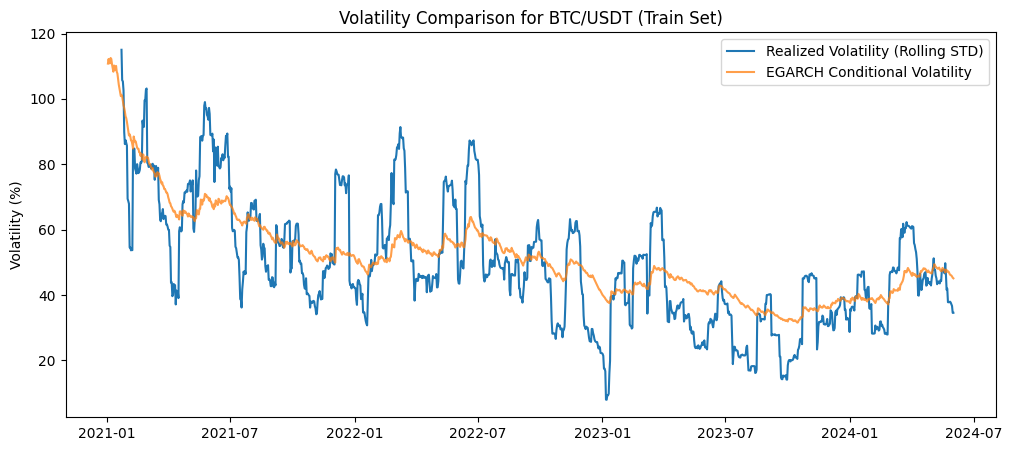

In [ ]:
# Define a function to fit EGARCH and evaluate on given returns
def egarch_analysis(returns, symbol, rolling_window=21):
    print(f"\n=== EGARCH(1,1) Model for {symbol} ===")

    # Fit EGARCH(1,1) model to returns in percent (common scaling)
    am = arch_model(returns * 100, vol='EGARCH', p=1, q=1, dist='normal', mean='Zero')
    res = am.fit(update_freq=5, disp='off')
    print(res.summary())

    # Extract AIC and BIC
    print(f"AIC: {res.aic:.4f}, BIC: {res.bic:.4f}")

    # Ljung-Box test on squared standardized residuals (tests for ARCH effects)
    lb_test = acorr_ljungbox(res.std_resid ** 2, lags=[10], return_df=True)
    print("\nLjung-Box test for ARCH effects (p-value):")
    print(lb_test)

    # Calculate realized volatility (rolling std dev of returns scaled to annualized vol)
    realized_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252) * 100  # % annualized

    # EGARCH conditional volatility (annualized approx. because data is daily * 100)
    cond_vol = res.conditional_volatility * np.sqrt(252)  # annualized

    # Plot realized vs conditional volatility
    plt.figure(figsize=(12,5))
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (Rolling STD)')
    plt.plot(cond_vol.index, cond_vol, label='EGARCH Conditional Volatility', alpha=0.75)
    plt.title(f'Volatility Comparison for {symbol}')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

    return res

# Select train returns
btc_train_returns = train_df['btc_return'].dropna()
btc_res_train = egarch_analysis(btc_train_returns, 'BTC/USDT (Train Set)')


=== EGARCH(1,1) Model for BTC/USDT (Test Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             btc_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                     EGARCH   Log-Likelihood:               -733.947
Distribution:                  Normal   AIC:                           1473.89
Method:            Maximum Likelihood   BIC:                           1485.12
                                        No. Observations:                  312
Date:                Wed, May 21 2025   Df Residuals:                      312
Time:                        15:59:17   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.29

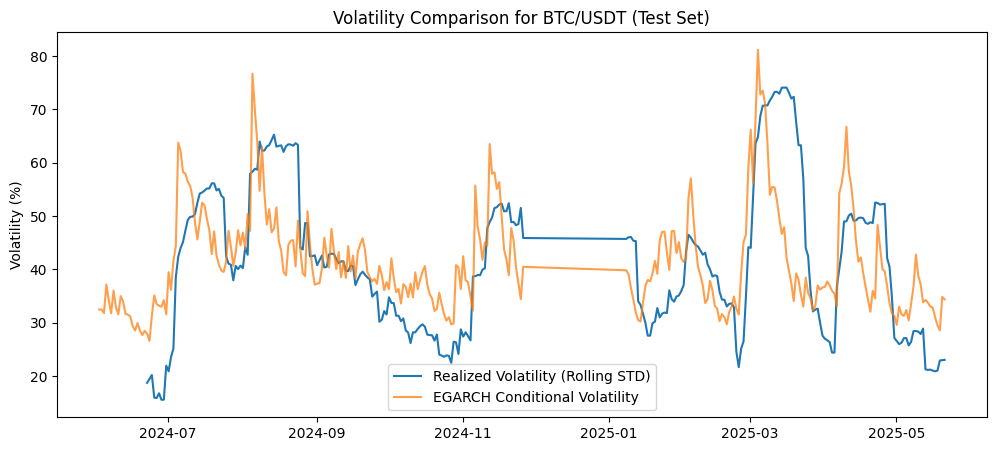

In [ ]:
# Run EGARCH analysis on test data returns only
btc_test_returns = test_df['btc_return'].dropna()
btc_res_test = egarch_analysis(btc_test_returns, 'BTC/USDT (Test Set)')

GARCH model on ETH/USD Train and Test data


=== EGARCH(1,1) Model for ETH/USD (Train Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             eth_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -3430.44
Distribution:                  Normal   AIC:                           6866.88
Method:            Maximum Likelihood   BIC:                           6882.26
                                        No. Observations:                 1247
Date:                Wed, May 21 2025   Df Residuals:                     1247
Time:                        15:59:17   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega     

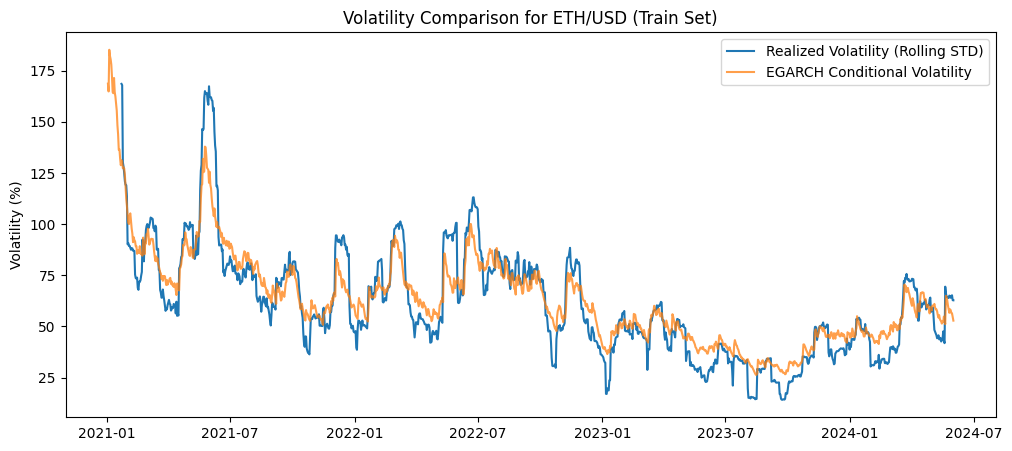

In [ ]:
# Define a function to fit EGARCH and evaluate
def egarch_analysis(returns, symbol, rolling_window=21):
    print(f"\n=== EGARCH(1,1) Model for {symbol} ===")

    # Fit EGARCH(1,1) model to returns in percent (common scaling)
    am = arch_model(returns * 100, vol='EGARCH', p=1, q=1, dist='normal', mean='Zero')
    res = am.fit(update_freq=5, disp='off')
    print(res.summary())

    # Extract AIC and BIC
    print(f"AIC: {res.aic:.4f}, BIC: {res.bic:.4f}")

    # Ljung-Box test on squared standardized residuals (tests for ARCH effects)
    lb_test = acorr_ljungbox(res.std_resid ** 2, lags=[10], return_df=True)
    print("\nLjung-Box test for ARCH effects (p-value):")
    print(lb_test)

    # Calculate realized volatility (rolling std dev of returns scaled to annualized vol)
    realized_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252) * 100  # % annualized

    # EGARCH conditional volatility (already annualized approx. because data is daily * 100)
    cond_vol = res.conditional_volatility * np.sqrt(252)  # annualized

    # Plot realized vs conditional volatility
    plt.figure(figsize=(12,5))
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (Rolling STD)')
    plt.plot(cond_vol.index, cond_vol, label='EGARCH Conditional Volatility', alpha=0.75)
    plt.title(f'Volatility Comparison for {symbol}')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

    return res

eth_train_returns = train_df['eth_return'].dropna()
eth_res_train = egarch_analysis(eth_train_returns, 'ETH/USD (Train Set)')


=== EGARCH(1,1) Model for ETH/USD (Test Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             eth_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                     EGARCH   Log-Likelihood:               -861.460
Distribution:                  Normal   AIC:                           1728.92
Method:            Maximum Likelihood   BIC:                           1740.15
                                        No. Observations:                  312
Date:                Wed, May 21 2025   Df Residuals:                      312
Time:                        15:59:18   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega      

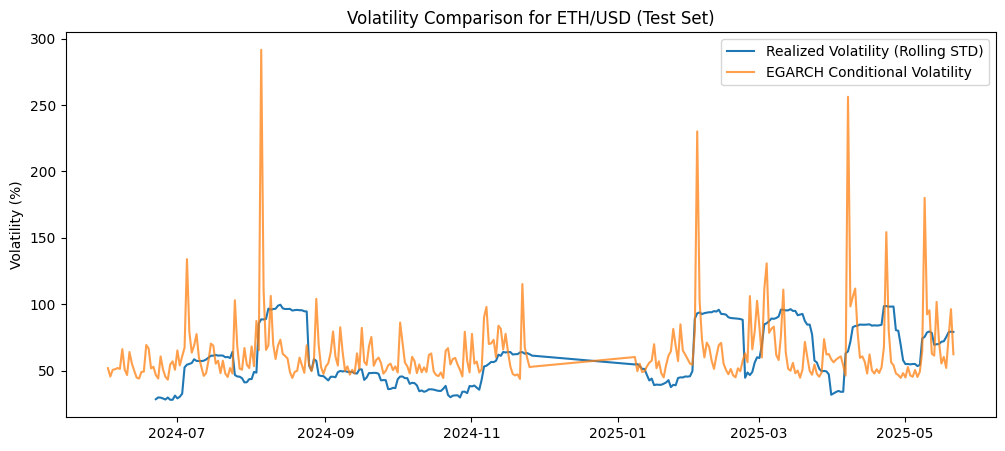

In [ ]:
# Run EGARCH on ETH returns (Test Set)
eth_test_returns = test_df['eth_return'].dropna()
eth_res_test = egarch_analysis(eth_test_returns, 'ETH/USD (Test Set)')

##LSTM with Attention Mechanism


In [ ]:
# Compute Spread
price_df['spread'] = price_df['eth_close_scaled'] - price_df['btc_close_scaled']

# Apply EGARCH volatility forecasts
price_df['btc_vol'] = np.nan
price_df['eth_vol'] = np.nan
price_df.loc[btc_res_train.conditional_volatility.index, 'btc_vol'] = btc_res_train.conditional_volatility / 100
price_df.loc[eth_res_train.conditional_volatility.index, 'eth_vol'] = eth_res_train.conditional_volatility / 100
price_df.dropna(subset=['spread', 'btc_vol', 'eth_vol'], inplace=True)

In [ ]:
# Create Sequence
def create_sequences(df, seq_len=30):
    X, y_signal, y_vol = [], [], []
    for i in range(len(df) - seq_len):
        window = df[['spread','btc_vol','eth_vol']].iloc[i:i+seq_len].values
        fut = df['spread'].iloc[i+seq_len]
        mu, sigma = df['spread'].iloc[i:i+seq_len].mean(), df['spread'].iloc[i:i+seq_len].std()
        # classification target
        if fut > mu + sigma:
            sig = [1,0,0]
        elif fut < mu - sigma:
            sig = [0,1,0]
        else:
            sig = [0,0,1]
        X.append(window)
        y_signal.append(sig)
        y_vol.append(fut)
    return np.array(X), np.array(y_signal), np.array(y_vol)

seq_len = 30
X, y_signal, y_vol = create_sequences(price_df, seq_len)

# train-test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_signal[:train_size], y_signal[train_size:]
vol_train, vol_test = y_vol[:train_size], y_vol[train_size:]

In [ ]:
# LSTM with Attention Model
def build_lstm_attention_model(seq_len, n_features, n_heads=4):
    inp = Input((seq_len, n_features))
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Dropout(0.2)(x)
    attn = MultiHeadAttention(num_heads=n_heads, key_dim=64)(x, x)
    x = tf.keras.layers.LayerNormalization()(x + attn)
    # temporal attention
    scores = Dense(1, activation='tanh')(x)
    weights = tf.keras.layers.Softmax(axis=1)(scores)
    context = Lambda(lambda t: tf.reduce_sum(t[0]*t[1], axis=1))([x, weights])
    # outputs
    signal_out = Dense(3, activation='softmax', name='signal')(context)
    vol_out = Dense(1, activation='linear', name='vol')(context)
    model = Model(inp, [signal_out, vol_out])
    model.compile(
        optimizer=Adam(1e-3),
        loss={'signal': 'categorical_crossentropy', 'vol': 'mse'},
        metrics={'signal': 'accuracy', 'vol': 'mse'}
    )
    return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    135,168 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 256)   │    263,168 │ dropout[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 256)   │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 1)     │        257 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 30, 1)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ layer_normalizat… │
│                     │                   │            │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ signal (Dense)      │ (None, 3)         │        771 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vol (Dense)         │ (None, 1)         │        257 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 400,133 (1.53 MB)

 Trainable params: 400,133 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step - loss: 2.1859 - signal_accuracy: 0.4655 - signal_loss: 1.0679 - vol_loss: 1.1176 - vol_mse: 1.1182 - val_loss: 1.1175 - val_signal_accuracy: 0.4057 - val_signal_loss: 1.1165 - val_vol_loss: 0.0132 - val_vol_mse: 0.0136
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 1.0572 - signal_accuracy: 0.4777 - signal_loss: 1.0422 - vol_loss: 0.0149 - vol_mse: 0.0149 - val_loss: 1.0594 - val_signal_accuracy: 0.4303 - val_signal_loss: 1.0608 - val_vol_loss: 0.0037 - val_vol_mse: 0.0037
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 1.0499 - signal_accuracy: 0.4815 - signal_loss: 1.0442 - vol_loss: 0.0055 - vol_mse: 0.0055 - val_loss: 1.0400 - val_signal_accuracy: 0.4057 - val_signal_loss: 1.0521 - val_vol_loss: 0.0014 - val_vol_mse: 0.0012
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.9762 - signal_accuracy: 0.5079 - signal_loss: 0.9721 - vol_loss: 0.0040 - vol_mse: 0.0040 - val_loss: 1.0209 - val_signal

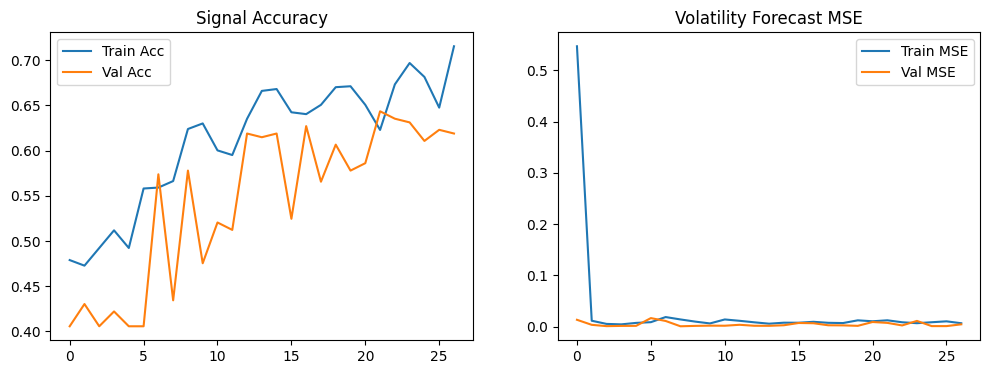

In [ ]:
# Build and Train Model
model = build_lstm_attention_model(seq_len, n_features=3)
model.summary()

# Callbacks
ess = tf.keras.callbacks.EarlyStopping(monitor='val_signal_accuracy', patience=5, mode='max', restore_best_weights=True)

history = model.fit(
    X_train, {'signal': y_train, 'vol': vol_train},
    validation_data=(X_test, {'signal': y_test, 'vol': vol_test}),
    epochs=50,
    batch_size=32,
    callbacks=[ess]
)

# Plot Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['signal_accuracy'], label='Train Acc')
plt.plot(history.history['val_signal_accuracy'], label='Val Acc')
plt.title('Signal Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['vol_mse'], label='Train MSE')
plt.plot(history.history['val_vol_mse'], label='Val MSE')
plt.title('Volatility Forecast MSE')
plt.legend()
plt.show()


In [ ]:
# explainer = shap.DeepExplainer(model, X_train)
X_train[:2]

array([[[-0.19236551,  0.06979475,  0.10625775],
        [-0.10770231,  0.0706823 ,  0.10387639],
        [-0.10634061,  0.06986802,  0.11670627],
        [-0.12736829,  0.06984709,  0.11481596],
        [-0.12603556,  0.07087104,  0.11378563],
        [-0.14815144,  0.07067046,  0.11211714],
        [-0.15277074,  0.06967321,  0.10828593],
        [-0.13316025,  0.06897985,  0.10365394],
        [-0.13062292,  0.06823543,  0.10332675],
        [-0.1304241 ,  0.06942322,  0.108024  ],
        [-0.12575328,  0.06861934,  0.10368209],
        [-0.15261239,  0.06861824,  0.10234819],
        [-0.13660449,  0.06934647,  0.10018494],
        [-0.12193244,  0.06822801,  0.09799839],
        [-0.10531885,  0.0678681 ,  0.09348775],
        [-0.10499391,  0.06681386,  0.0906451 ],
        [-0.08642135,  0.0657318 ,  0.08587348],
        [-0.06677306,  0.06498204,  0.08603952],
        [-0.07228937,  0.06419944,  0.08316508],
        [-0.07533979,  0.06352494,  0.08117306],
        [-0.06963424

##BackTesting with RSI filter


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Total Return: 114.20%
Sharpe Ratio: 0.89
Maximum Drawdown: -9.61%


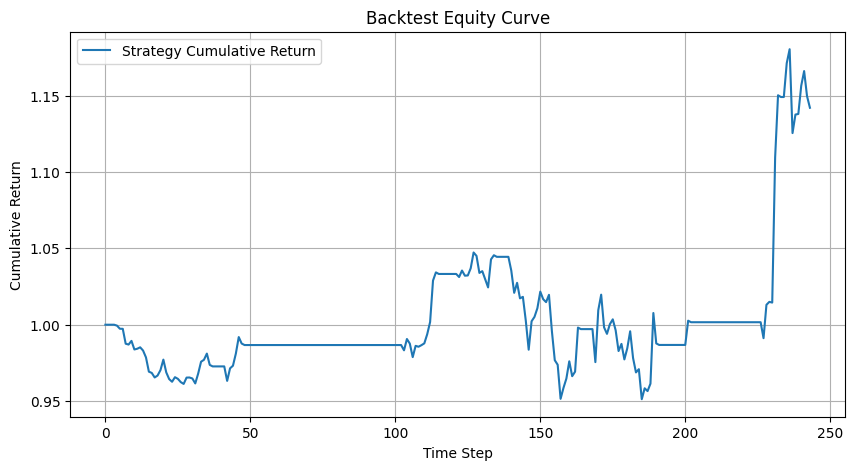

In [64]:
# Predict with LSTM
y_pred_probs, y_vol_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred_probs, axis=1)

signal_map = {0: 1, 1: -1, 2: 0}
predicted_signals = - np.array([signal_map[c] for c in y_pred_class])

# Compute Returns
spread_test = y_vol[train_size:]
spread_returns = np.diff(spread_test, prepend=spread_test[0])
strategy_returns = predicted_signals * spread_returns

transaction_cost = 0.001
signal_change = np.abs(np.diff(filtered_signals, prepend=0))
costs = signal_change * transaction_cost
net_returns = strategy_returns - costs
cumulative_returns = np.cumprod(1 + net_returns)

# Performance
total_return = cumulative_returns[-1]
sharpe_ratio = np.mean(net_returns) / np.std(net_returns) * np.sqrt(252)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")

# Performance Plot
plt.figure(figsize=(10,5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.title('Backtest Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Total Return: 132.94%
Sharpe Ratio: 2.01
Maximum Drawdown: -7.75%


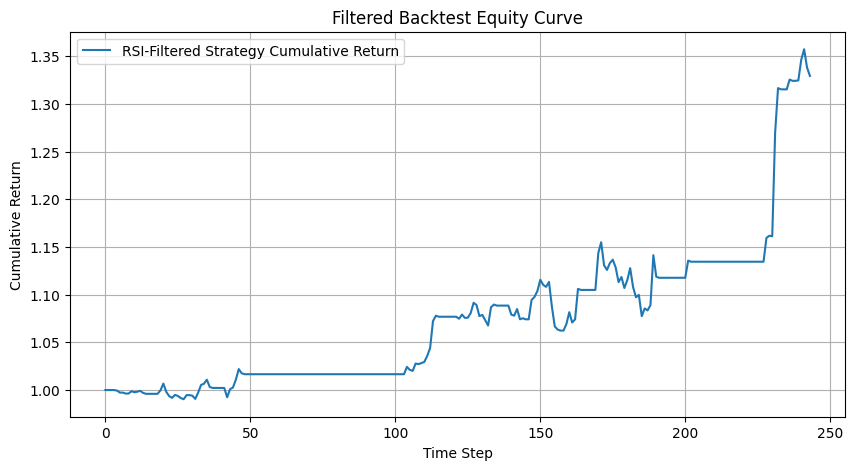

In [ ]:
# Compute RSI
price_df['rsi'] = ta.momentum.RSIIndicator(close=price_df['spread'], window=14).rsi()

# Predict with LSTM
y_pred_probs, y_vol_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred_probs, axis=1)

signal_map = {0: 1, 1: -1, 2: 0}
predicted_signals = np.array([signal_map[c] for c in y_pred_class])

# Apply RSI Filter
rsi_test = price_df['rsi'].values[train_size + seq_len : train_size + seq_len + len(X_test)]  # Corrected line

filtered_signals = -(np.where((predicted_signals == 1) & (rsi_test < 70), 1,
                    np.where((predicted_signals == -1) & (rsi_test > 30), -1, 0)))

# Compute Returns
spread_test = y_vol[train_size:]
spread_returns = np.diff(spread_test, prepend=spread_test[0])
strategy_returns = filtered_signals * spread_returns

transaction_cost = 0.001
signal_change = np.abs(np.diff(filtered_signals, prepend=0))
costs = signal_change * transaction_cost
net_returns = strategy_returns - costs
cumulative_returns = np.cumprod(1 + net_returns)

# Performance
total_return = cumulative_returns[-1]
sharpe_ratio = np.mean(net_returns) / np.std(net_returns) * np.sqrt(252)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")

# Performance Plot
plt.figure(figsize=(10,5))
plt.plot(cumulative_returns, label='RSI-Filtered Strategy Cumulative Return')
plt.title('Filtered Backtest Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()
